In [225]:
import numpy as np
import math
import statsmodels.api as sm
import imblearn
from tqdm.notebook import tqdm
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite, community 
from numpy import nansum
from numpy import nanmean
from numpy.random import choice
import itertools
from networkx.algorithms import community
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
pd.set_option('display.max_columns', None)

## Bipartite network generation

### Data preparation

In [109]:
cb1 = pd.read_csv('cb1.csv')
cb2 = pd.read_csv('cb2.csv')
cb3 = pd.read_csv('cb3.csv')

In [110]:
cb = cb1.append(cb2)
cb = cb.append(cb3)
cb.index = range(len(cb))

In [111]:
cb['date']

0         05/16/1949
1         05/16/1949
2         05/16/1949
3         05/16/1949
4         05/16/1949
             ...    
187799    08/17/2021
187800    08/17/2021
187801    08/17/2021
187802    08/17/2021
187803    08/17/2021
Name: date, Length: 187804, dtype: object

In [114]:
cb['date_my'] = (pd.to_datetime(cb['date'],format='%m/%d/%Y', errors='coerce')).dt.to_period('m')
cb['date_y'] = (pd.to_datetime(cb['date'],format='%m/%d/%Y', errors='coerce')).dt.to_period('y')

# DESCRIZIONE

In [65]:
cb.groupby(['target_continent','investor_continent']).size().unstack(fill_value=0)

investor_continent,Africa,Asia,Australia,Europe,North America,South America
target_continent,,,,,,
Africa,250,48,3,112,89,0
Asia,34,17058,35,705,2257,6
Australia,0,49,523,60,186,1
Europe,16,656,75,21472,3658,35
North America,45,3595,313,6264,75739,55
South America,0,14,4,99,182,464


In [66]:
cb_a = cb.groupby(['target_continent','investor_continent']).size().unstack(fill_value=0)
cb_a["sum"] = cb_a.sum(axis = 0)
cb_a = cb_a.loc[:,"Africa":"South America"].div(cb_a["sum"], axis=0)
cb_a

investor_continent,Africa,Asia,Australia,Europe,North America,South America
target_continent,,,,,,
Africa,0.724638,0.139130,0.008696,0.324638,0.257971,0.000000
Asia,0.001587,0.796359,0.001634,0.032913,0.105369,0.000280
Australia,0.000000,0.051417,0.548793,0.062959,0.195173,0.001049
Europe,0.000557,0.022848,0.002612,0.747841,0.127403,0.001219
North America,0.000548,0.043782,0.003812,0.076287,0.922398,0.000670
South America,0.000000,0.024955,0.007130,0.176471,0.324421,0.827094


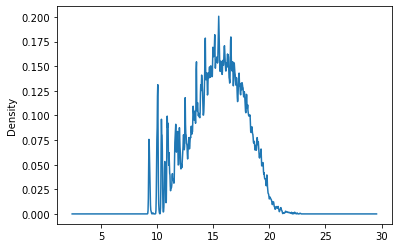

In [219]:
es1 = cb.groupby(['target_name','stage'], as_index = False).agg({"size_real": 'first'})
es2 = es1[['target_name','size_real']].groupby(['target_name'],as_index=False).sum()
es3 = es2[es2['size_real']!=0]
np.log(es3['size_real']).plot.kde(0.01)

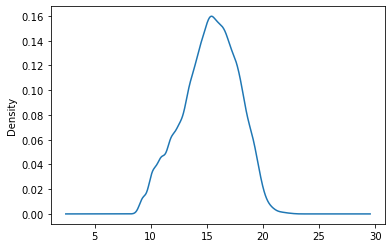

In [215]:
np.log(es3['size_real']).plot.kde()

In [223]:
es3.sort_values("size_real",ascending=False)[0:50]

,target_name,size_real
13696,DuPont Nutrition & Biosciences,7.746618e+09
17516,Genentech,7.290045e+09
23740,Kindred at Home,5.853121e+09
40403,Siemens Healthineers,5.710232e+09
38407,Roche Holding,5.000450e+09
5675,BeiGene,4.797594e+09
18689,HCA Healthcare,4.650897e+09
1110,Acerta Pharma,4.625006e+09
8372,Canopy Growth,4.520272e+09
5514,Bayer,4.050744e+09


In [149]:
cb[cb['target_name']=='zumutor']

,target_name,stage,size_MLN,date,investors_name,url,description,industry,target_country,target_collections,target_status,target_ID,target_founded,round_simp,target_continent,target_state,target_city,target_street,target_people,target_competitors,investor_name,investor_url,investor_description,investor_country,investor_type,investor_deals_now,investor_companies,investor_deals_total,investor_exit_12,investor_ppl,investor_deals_12,investor_collections,investor_id,investor_industry,investor_state,investor_continent,investor_city,investor_founded,investor_street,date_dt,DATE,CPIAUCSL,size_real,date_my,date_y
4161,zumutor,Other Investors,NaN,NaN,Chiratae Ventures,zumutor.com,Zumutor is an immuno-oncology company that dev...,Biotechnology,United States,"Regenerative Medicine, Biopharmaceuticals and ...",Alive / Active,348607,2013.0,Other Investors,North America,Massachusetts,Cambridge,CIC Cambridge Campus 1 Broadway…,"Kavitha Rodrigues (CEO),Anirban Bhattacharya (...",NaN,Chiratae Ventures,chiratae.com,"Chiratae Ventures, formerly IDG Ventures India...",India,Venture Capital,44.0,19.0,256,3.0,"T. Meenakshisundaram (CFO),Manik Arora (Managi...",51.0,"Pharma Startups, Fitness Tech and Untitled…",1572.0,NaN,NaN,Asia,Bengaluru,2006.0,"7B, 7th Floor, Sobha Pearl 1, Commissariat Road…",NaN,NaN,NaN,NaN,NaT,NaT
151846,zumutor,Series A,4.0,11/27/2019,Accel,zumutor.com,Zumutor is an immuno-oncology company that dev...,Biotechnology,United States,"Regenerative Medicine, Biopharmaceuticals and ...",Alive / Active,348607,2013.0,Series A,North America,Massachusetts,Cambridge,CIC Cambridge Campus 1 Broadway…,"Kavitha Rodrigues (CEO),Anirban Bhattacharya (...",NaN,Accel,accel.com,Accel is a venture capital firm that invests i...,United States,Venture Capital,115.0,58.0,"2,061",33.0,NaN,176.0,"Identity Management, Direct-To-Consumer Brands...",203.0,Investment Firms & Funds,California,North America,Palo Alto,1983.0,500 University Avenue,2019-11,2019-11,257.989,4.248243e+06,2019-11,2019
151847,zumutor,Series A,4.0,11/27/2019,Bharat Fund,zumutor.com,Zumutor is an immuno-oncology company that dev...,Biotechnology,United States,"Regenerative Medicine, Biopharmaceuticals and ...",Alive / Active,348607,2013.0,Series A,North America,Massachusetts,Cambridge,CIC Cambridge Campus 1 Broadway…,"Kavitha Rodrigues (CEO),Anirban Bhattacharya (...",NaN,Bharat Fund,bharat.fund,Bharat Fund is an early stage venture fund wit...,India,Venture Capital,1.0,1.0,10,0.0,NaN,4.0,NaN,100506.0,NaN,NaN,Asia,Ahmedabad,NaN,Centre for Innovation Incubation and Entrepren...,2019-11,2019-11,257.989,4.248243e+06,2019-11,2019


In [129]:
cb

,target_name,stage,size_MLN,date,investors_name,url,description,industry,target_country,target_collections,target_status,target_ID,target_founded,round_simp,target_continent,target_state,target_city,target_street,target_people,target_competitors,investor_name,investor_url,investor_description,investor_country,investor_type,investor_deals_now,investor_companies,investor_deals_total,investor_exit_12,investor_ppl,investor_deals_12,investor_collections,investor_id,investor_industry,investor_state,investor_continent,investor_city,investor_founded,investor_street,date_dt,DATE,CPIAUCSL,size_real,date_my,date_y
0,Shionogi & Co.,IPO,NaN,05/16/1949,Public,shionogi.com,Shionogi & Co. (TYO: 4507) focuses on the rese...,Pharmaceuticals / Drugs,Japan,Pharma Startups,IPO / Went public,262824,1878.0,IPO,Asia,NaN,Osaka,"1-8, Doshomachi 3-chome Chuo-ku…",NaN,Sumitomo Dainippon Pharma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949-05,1949-05,23.91,NaN,1949-05,1949
1,Astellas Pharma,IPO,NaN,05/16/1949,Public,astellas.com,Astellas Pharma (TSE: 4503) specializes in the...,Pharmaceuticals / Drugs,Japan,"Digital Therapeutics, Pharma Startups, Cancer ...",IPO / Went public,243168,1923.0,IPO,Asia,NaN,Tokyo,"2-5-1, Nihonbashi-Honcho, Chuo-ku…","Yoshihiko Hatanaka (CEO),Yoshirou Myyokawa (EV...",Sumitomo Dainippon Pharma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949-05,1949-05,23.91,NaN,1949-05,1949
2,Sumitomo Dainippon Pharma,IPO,NaN,05/16/1949,Public,ds-pharma.com,Sumitomo Dainippon Pharma (TYO: 4506) is a pha...,Pharmaceuticals / Drugs,Japan,Digital Therapeutics and Pharma Startups…,IPO / Went public,447180,1897.0,IPO,Asia,NaN,Osaka,"6-8, Doshomachi 2-chome Chuo-ku…",Masayo Tada (CEO),"Astellas Pharma,Chugai Pharmaceutical,Daiichi ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949-05,1949-05,23.91,NaN,1949-05,1949
3,Konica Minolta,IPO,NaN,05/16/1949,Public,konicaminolta.com,"Konica Minolta (コニカミノルタ) (TYO: 4902), founded ...",Medical Devices & Equipment,Japan,Conference Exhibitors,IPO / Went public,57191,1936.0,IPO,Asia,NaN,Tokyo,"JP Tower 2-7-2 Marunouchi, Chiyoda-ku…",Michael Mathé (SVP),Xerox,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949-05,1949-05,23.91,NaN,1949-05,1949
4,Takeda Pharmaceutical,IPO,NaN,05/16/1949,Public,takeda.com,Takeda Pharmaceutical (TYO: 4502) (NYSE: TAK) ...,Pharmaceuticals / Drugs,Japan,"Poop Tech, Pharma Startups, Rare Diseases, Sle...",IPO / Went public,373007,1781.0,IPO,Asia,NaN,Tokyo,"2-1-1 Nihonbashihonmachi, Chuo-ku…","Frank Morich (CEO),Yasuchika Hasegawa (CEO),Da...","Sumitomo Dainippon Pharma,Sunovion…",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949-05,1949-05,23.91,NaN,1949-05,1949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187799,Beijing Shouyi,Acquired,NaN,08/17/2021,Healgen,shouyi-biochem.com…,"Beijing Shouyi is a biomedical enterprise, whi...",Medical Devices & Equipment,China,NaN,Acquired,669346,1998.0,Acquisition,Asia,Beijing,Beijing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-08,2021-08,274.00,NaN,2021-08,2021
187800,Centaur Labs,Series A,15.89,08/17/2021,Undisclosed Investors,centaurlabs.com,Centaur Labs enables customers to build AI alg...,Internet Software & Services,United States,"Digital Health, Artificial Intelligence ( AI )...",Alive / Active,377820,2017.0,Series A,North America,Massachusetts,Boston,"883 Boylston St, Suite 200…","Erik Duhaime (CEO),Zach Rausnitz (CTO)…",Aigorithm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-08,2021-08,274.00,15890000.0,2021-08,2021
187801,Streamline Health Solutions,IPO,NaN,08/17/2021,Public,streamlinehealth.net,Streamline Health (NASDAQ: STRM) provides solu...,Healthcare Softwa

In [226]:
cb[cb['investors_name']=='Streamline Health Solutions']

,target_name,stage,size_MLN,date,investors_name,url,description,industry,target_country,target_collections,target_status,target_ID,target_founded,round_simp,target_continent,target_state,target_city,target_street,target_people,target_competitors,investor_name,investor_url,investor_description,investor_country,investor_type,investor_deals_now,investor_companies,investor_deals_total,investor_exit_12,investor_ppl,investor_deals_12,investor_collections,investor_id,investor_industry,investor_state,investor_continent,investor_city,investor_founded,investor_street,date_dt,DATE,CPIAUCSL,size_real,date_my,date_y
187802,Avelead,Acquired,NaN,08/17/2021,Streamline Health Solutions,avelead.com,Avelead provides a cloud-based platform for ho...,Internet Software & Services,United States,"Digital Health, Startups Streamlining Healthca...",Acquired,439775,2014.0,Acquisition,North America,Georgia,Suwanee,1172 Satellite Boulevard Suite 100…,NaN,NaN,Streamline Health Solutions,streamlinehealth.net,Streamline Health (NASDAQ: STRM) provides solu...,United States,Corporation,1.0,1.0,1,0.0,NaN,1.0,NaN,152741.0,Healthcare Software,Ohio,North America,Cincinnati,NaN,10200 Alliance Road Suite 200…,2021-08,2021-08,274.0,NaN,2021-08,2021


In [318]:
#ordinare gli investitori

inv_list = list(cb['investors_name'].values)
inv_counter = {}
for inv in inv_list:
    if inv in inv_counter:
        inv_counter[inv] += 1
    else:
        inv_counter[inv] = 1

popular_invs = sorted(inv_counter, key = inv_counter.get, reverse = True)
 
top = popular_invs[:20]

In [319]:
popular_invs

['Undisclosed Investors',
 'Public',
 'Undisclosed Angel Investors',
 'Undisclosed Venture Investors',
 'Paycheck Protection Program',
 'New Enterprise Associates',
 'OrbiMed Advisors',
 'Domain Associates',
 'National Institutes of Health',
 'MassChallenge',
 'Versant Ventures',
 'Polaris Partners',
 'MPM Capital',
 'National Science Foundation',
 'Venrock',
 'ARCH Venture Partners',
 'SV Health Investors',
 'Alta Partners',
 'Dead',
 'Y Combinator',
 'InterWest Partners',
 'SOSV',
 'Kleiner Perkins Caufield & Byers',
 'Horizon 2020',
 'Johnson & Johnson Innovation',
 'Frazier Healthcare Partners',
 'Novartis Venture Funds',
 'JLabs',
 'Atlas Venture',
 'Qiming Venture Partners',
 '3i Group',
 'Vivo Capital',
 'SR One',
 'Canaan Partners',
 'F-Prime Capital',
 'Delphi Ventures',
 'U.S. Department of Health and Human Services',
 'High-Tech Grunderfonds',
 'Qualifying Therapeutic Discovery Project',
 'Alexandria Venture Investments',
 'Oxford Bioscience Partners',
 'Flagship Pioneering'

# GRAPHS

In [266]:
nodes_org = cb[['target_name', 'target_ID']].drop_duplicates()
nodes_org['bipartite'] = 1
nodes_inv = cb[['investors_name', 'investor_id']].drop_duplicates()
nodes_org = nodes_org.rename(columns={"target_name": "node", "target_country": "country", 
                                      "target_continent": "continent", "industry":"industry",
                                     "target_ID":"index"})
nodes_inv = nodes_inv.rename(columns={"investors_name": "node","investor_country": "country", 
                                      "investor_continent": "continent", "investor_type":"industry","investor_id":'index' })
nodes_inv['bipartite'] = 0
nodes = nodes_org.append(nodes_inv, ignore_index= True)
nodes['id'] = nodes.index
nodes

,node,index,bipartite,id
0,Shionogi & Co.,262824.0,1,0
1,Astellas Pharma,243168.0,1,1
2,Sumitomo Dainippon Pharma,447180.0,1,2
3,Konica Minolta,57191.0,1,3
4,Takeda Pharmaceutical,373007.0,1,4
...,...,...,...,...
83253,Shenzhen Qianhai Beizeng Asset Management Co. ...,179782.0,0,83253
83254,Wuxi High-Tech District Seed Fund,189318.0,0,83254
83255,Edvantage Group,190377.0,0,83255
83256,Healgen,NaN,0,83256


In [241]:
numbers = cb.groupby(['target_name','stage'], as_index = False).count()[['target_name','stage','investors_name']].rename(columns={"investors_name": "investor_numbers"})

In [242]:
cb_new = pd.merge(cb, numbers,  how='left', left_on=['target_name','stage'], right_on = ['target_name','stage'])
cb_new = pd.merge(cb_new, nodes[nodes['bipartite']== 1],  how='left', left_on=['target_name','target_ID'], right_on = ['node','index'])
cb_new = pd.merge(cb_new, nodes[nodes['bipartite']== 0],  how='left', left_on=['investors_name','investor_id'], right_on = ['node','index'])


In [293]:
##ripeto quanto fatto prima (semplificato prima per risparmiare tempo) ma aggiungo roba
nodes_org = cb_new[['target_name', 'target_ID', 'target_country', 'target_continent',
               'industry','target_founded','target_status']].drop_duplicates()
nodes_org['bipartite'] = 1
nodes_inv = cb_new[['investors_name', 'investor_id', 'investor_country', 'investor_continent', 'investor_type',
                   'investor_founded']].drop_duplicates()
nodes_org = nodes_org.rename(columns={"target_name": "node", "target_country": "country", 
                                      "target_continent": "continent", "industry":"industry",
                                     "target_ID":"index", "target_founded":"foundation"})
nodes_inv = nodes_inv.rename(columns={"investors_name": "node","investor_country": "country", 
                                      "investor_continent": "continent", "investor_type":"industry", "investor_id":'index',
                                     "investor_founded":"foundation"})
nodes_inv['bipartite'] = 0
nodes = nodes_org.append(nodes_inv, ignore_index= True)
nodes['id'] = nodes.index
nodes.columns



Index(['node', 'index', 'country', 'continent', 'industry', 'foundation',
       'target_status', 'bipartite', 'id'],
      dtype='object')

In [294]:
B = nx.MultiGraph(name='org-bid')
# Add nodes with the node attribute "bipartite"
B.add_nodes_from(nodes[nodes.bipartite==0].id)
B.add_nodes_from(nodes[nodes.bipartite==1].id)
nx.set_node_attributes(B, pd.Series(nodes.node, index=nodes.id).to_dict(), 'name')
nx.set_node_attributes(B, pd.Series(nodes.country, index=nodes.id).to_dict(), 'country')
nx.set_node_attributes(B, pd.Series(nodes.continent, index=nodes.continent).to_dict(), 'continent')
nx.set_node_attributes(B, pd.Series(nodes.industry, index=nodes.id).to_dict(), 'industry')
nx.set_node_attributes(B, pd.Series(nodes.foundation, index=nodes.id).to_dict(), 'foundation')
nx.set_node_attributes(B, pd.Series(nodes.bipartite, index=nodes.id).to_dict(), 'bipartite')
nx.set_node_attributes(B, pd.Series(nodes.target_status, index=nodes.id).to_dict(), 'target_status')
# Add edges only between nodes of opposite node sets
for i in range(len(cb_new)):
    B.add_edge(cb_new.loc[i,'id_y'], cb_new.loc[i,'id_x'], date=(cb_new.loc[i,'date_y']).year, m_raised=cb_new.loc[i,'size_real'], 
               investors = cb_new.loc[i,'investor_numbers'], stage =cb_new.loc[i,'stage'])

In [296]:
##nodi brutti
#'Undisclosed Investors',
# 'Public',
#'Undisclosed Angel Investors',
#'Undisclosed Venture Investors',
#Dead


KeyError: 'na'

In [308]:
brutti = [x for x,y in B.nodes(data=True) if (y['name']=='Undisclosed Investors') or (y['name']=='Dead')   or (y['name']=='Public')  
          or  (y['name']=='Undisclosed Undisclosed Angel Investors') or (y['name']=='Undisclosed Venture Investors')]
B.remove_nodes_from(brutti)

# WINDOW

In [ ]:
from itertools import islice

def window(seq, n):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [ ]:
finestra = window(list(range(2000,2022)),5)

In [ ]:
for periodo in finestra:
    locals()["B_"+str(periodo[-1])]=nx.MultiGraph([(u,v,d) for u,v,d in B.edges(data=True) if d['date'] in periodo])

# COMMUNITIES

In [ ]:
partition = community_louvain.best_partition(G)

In [322]:
cb_new.groupby('stage').count()

,target_name,size_MLN,date,investors_name,url,description,industry,target_country,target_collections,target_status,target_ID,target_founded,round_simp,target_continent,target_state,target_city,target_street,target_people,target_competitors,investor_name,investor_url,investor_description,investor_country,investor_type,investor_deals_now,investor_companies,investor_deals_total,investor_exit_12,investor_ppl,investor_deals_12,investor_collections,investor_id,investor_industry,investor_state,investor_continent,investor_city,investor_founded,investor_street,date_dt,DATE,CPIAUCSL,size_real,date_my,date_y,investor_numbers,node_x,index_x,bipartite_x,id_x,node_y,index_y,bipartite_y,id_y
stage,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Acq - Fin,2210,77,2191,2210,2072,2210,2185,2206,730,2210,2210,1130,2210,2206,1440,2079,2057,1446,221,2122,2067,2100,2095,2106,2122,2122,2122,2122,1657,2122,937,2122,855,1569,2095,2028,1065,2044,2191,2191,2191,77,2191,2191,2210,2210,2210,2210,2210,2210,2122,2210,2210
Acq - Fin - II,248,6,248,248,243,248,248,248,86,248,248,174,248,248,152,240,239,184,38,243,238,241,240,242,243,243,243,243,193,243,110,243,111,173,240,238,149,237,248,248,248,6,248,248,248,248,248,248,248,248,243,248,248
Acq - Fin - III,53,1,53,53,53,53,53,53,26,53,53,39,53,53,36,52,52,41,8,51,51,51,51,51,51,51,51,51,41,51,34,51,31,31,51,50,37,51,53,53,53,1,53,53,53,53,53,53,53,53,51,53,53
Acq - Fin - IV,7,0,7,7,7,7,7,7,4,7,7,7,7,7,7,7,7,2,0,6,6,6,6,6,6,6,6,6,4,6,5,6,4,3,6,6,6,6,7,7,7,0,7,7,7,7,7,7,7,7,6,7,7
Acq - P2P,458,2,458,458,404,458,455,456,335,458,458,291,458,456,390,444,429,266,201,458,445,456,452,450,458,458,458,458,294,458,401,458,398,321,452,446,377,442,458,458,458,2,458,458,458,458,458,458,458,458,458,458,458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Unattributed VC - XI,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Unattributed VC - XIII,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1
Unattributed VC - XIV,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
